
# Assignment 4 — Applied Machine Learning

# Questions
## 2.
As our true positive rate increases, I would expect we start increasing our false positive rate. We should see a trade-off between operating points that achieve higher Pd but also exhibit higher Pf, with stronger models pushing those points up-and-left (high Pd, low Pf) and away from the diagonal coin-flip line.

## 3. 
I would choose the MLP `hidden_layer_sizes=(100,)` for our use case here, most of my implementations have almost the same TPR and FPR after varying the hyperparamters, which shows robustness for this model on our dataset. With the MLP we are also getting the best true positive/false positive rate. Where we could have a true positive rate of about 71% and a false positive rate of about 6%. For fake-news screening, miss-labeling a fake article could be costly, so prioritizing a higher Pd fits the task’s risk profile.

## 4.
Using just the title, our best MLP achieved a TPR of ~0.71 and an FPR of ~0.06. After adding the full text of the articles that same model achieved ~0.99 TPR with a very small ~0.006 FPR. We gain so much as a result of adding the article text because the article body carries substantial discriminative information that cannot be conveyed in just a title. This is all getting successfuly captured by our TF-IDF.


# import our dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve

df_true = pd.read_csv('../datasets/True.csv')
df_fake= pd.read_csv('../datasets/Fake.csv')
df_true.head()


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [2]:
df_fake.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [3]:
# set fake to 1 and true to 0
df_true['class'] = 0
df_fake['class'] = 1

In [4]:
df_fake.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [5]:
# Combine our datasetes
df = pd.concat([df_fake, df_true])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   class    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [6]:
X = TfidfVectorizer(
    stop_words='english',
    max_features=50
).fit_transform(df['title'])

y = df['class'].values

# Quick test with a random forest classifier

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=None
)

rf = RandomForestClassifier(
    n_estimators=300, max_depth=None, random_state=42, n_jobs=-1, class_weight='balanced'
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary', pos_label=1) 
print({'accuracy': acc, 'f1': f1})

{'accuracy': 0.8180400890868597, 'f1': 0.8037472976219073}


# Train and plot 

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import numpy as np

def collect_operating_point(clf, X, y):
    thr = 0.5
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=28)
    tprs, fprs = [], []

    for tr, te in skf.split(X, y):
        clf.fit(X[tr], y[tr])
        p = clf.predict_proba(X[te])[:, 1]

        y_hat = (p >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y[te], y_hat).ravel()

        tprs.append(tp/(tp+fn+1e-9))
        fprs.append(fp/(fp+tn+1e-9))
    return float(np.mean(fprs)), float(np.mean(tprs))


In [9]:
def plot_roc_points(points, title):
    # points = list of (fpr, tpr, label)
    x = np.arange(0.001, 1, 0.01)
    plt.plot(x, x, '--', color=(0.6,0.6,0.6), label='coin flip')
    for fpr, tpr, label in points:
        plt.scatter(fpr, tpr, s=20, alpha=0.85, label=label)
    plt.xlabel('False Positive Rate (Pf)')
    plt.ylabel('True Positive Rate (Pd)')
    plt.title(title)
    plt.legend(loc='lower right', fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.show()


In [10]:
points = []

# Decision Tree
for d in [4, 8, 12]:
    for c in ['gini', 'entropy']:
        clf = DecisionTreeClassifier(max_depth=d, random_state=28, criterion=c)
        fpr, tpr = collect_operating_point(clf, X, y)
        points.append((fpr, tpr, f"DT depth={d} criterion={c}"))

# Random Forest
for n in [20, 60, 100]:
    for d in [2, 4, 6]:
        clf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=28, n_jobs=-1)
        fpr, tpr = collect_operating_point(clf, X, y)
        points.append((fpr, tpr, f"RF trees={n} depth={d}"))

# MLP
for h in [(10,), (50,), (100,)]:
    clf = MLPClassifier(hidden_layer_sizes=h, solver="sgd", activation="tanh",
                        max_iter=1000, random_state=28, alpha=1e-3,
                        learning_rate="adaptive", learning_rate_init=5e-2,
                        momentum=0.95, nesterovs_momentum=True)
    fpr, tpr = collect_operating_point(clf, X, y)
    points.append((fpr, tpr, f"MLP {h}"))



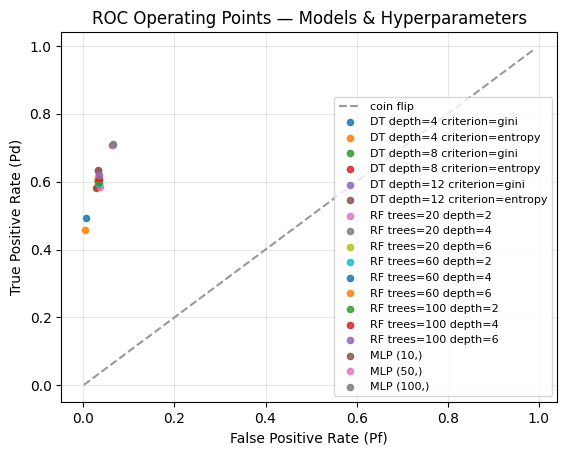

         fpr       tpr                          model
17  0.064389  0.709510                     MLP (100,)
16  0.064202  0.709042                      MLP (50,)
15  0.062848  0.706827                      MLP (10,)
5   0.032871  0.633065  DT depth=12 criterion=entropy
4   0.032591  0.632682     DT depth=12 criterion=gini
14  0.034039  0.619054           RF trees=100 depth=6
11  0.032264  0.613262            RF trees=60 depth=6
13  0.034599  0.607342           RF trees=100 depth=4
8   0.029650  0.605340            RF trees=20 depth=6
10  0.031751  0.601465            RF trees=60 depth=4
12  0.035159  0.599208           RF trees=100 depth=2
9   0.035299  0.594481            RF trees=60 depth=2
7   0.031564  0.594438            RF trees=20 depth=4
6   0.036607  0.585623            RF trees=20 depth=2
3   0.029276  0.582812   DT depth=8 criterion=entropy
2   0.027081  0.581662      DT depth=8 criterion=gini
0   0.006023  0.492909      DT depth=4 criterion=gini
1   0.004669  0.457136   DT 

In [11]:
plot_roc_points(points, "ROC Operating Points — Models & Hyperparameters")

#list model performance put points into a dataframe
df_points = pd.DataFrame(points, columns=['fpr', 'tpr', 'model'])

# sort the dataframe by the true positive rate
df_points = df_points.sort_values(by='tpr', ascending=False)
print(df_points)




# Adding Text Feature Along With Title

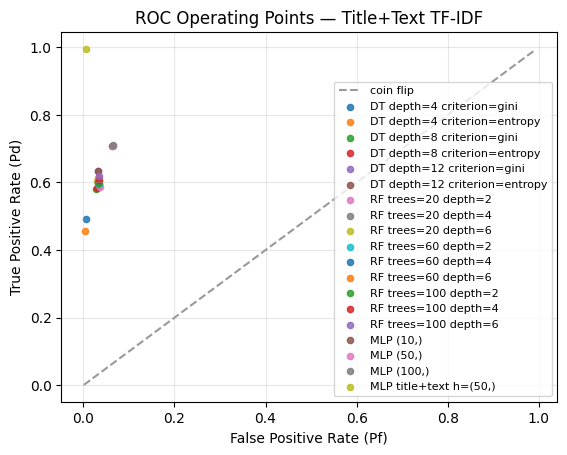

In [12]:
from scipy.sparse import hstack

# Build TF-IDF features for title and text
title_vectorizer = TfidfVectorizer(stop_words='english', max_features=50)
text_vectorizer  = TfidfVectorizer(stop_words='english', max_features=50)

X_title = title_vectorizer.fit_transform(df['title'])
X_text  = text_vectorizer.fit_transform(df['text'])
# Stack and convert to dense numpy array
X_tt = hstack([X_title, X_text]).toarray()

y = df['class'].values

mlp = MLPClassifier(hidden_layer_sizes=(50,), solver="sgd", activation="tanh", max_iter=1000, random_state=28, alpha=1e-3, learning_rate="adaptive", learning_rate_init=5e-2, momentum=0.95, nesterovs_momentum=True)

fpr, tpr = collect_operating_point(mlp, X_tt, y)
points.append((fpr, tpr, "MLP title+text h=(50,)"))

plot_roc_points(points, "ROC Operating Points — Title+Text TF-IDF")



In [13]:
#list model performance put points into a dataframe
df_points = pd.DataFrame(points, columns=['fpr', 'tpr', 'model'])

# sort the dataframe by the true positive rate
df_points = df_points.sort_values(by='tpr', ascending=False)
print(df_points)




         fpr       tpr                          model
18  0.006443  0.994932         MLP title+text h=(50,)
17  0.064389  0.709510                     MLP (100,)
16  0.064202  0.709042                      MLP (50,)
15  0.062848  0.706827                      MLP (10,)
5   0.032871  0.633065  DT depth=12 criterion=entropy
4   0.032591  0.632682     DT depth=12 criterion=gini
14  0.034039  0.619054           RF trees=100 depth=6
11  0.032264  0.613262            RF trees=60 depth=6
13  0.034599  0.607342           RF trees=100 depth=4
8   0.029650  0.605340            RF trees=20 depth=6
10  0.031751  0.601465            RF trees=60 depth=4
12  0.035159  0.599208           RF trees=100 depth=2
9   0.035299  0.594481            RF trees=60 depth=2
7   0.031564  0.594438            RF trees=20 depth=4
6   0.036607  0.585623            RF trees=20 depth=2
3   0.029276  0.582812   DT depth=8 criterion=entropy
2   0.027081  0.581662      DT depth=8 criterion=gini
0   0.006023  0.492909      